# Used vehicles price prediction - A Machine Learning Project
### by Alexander Justin King Sing Ortiz
*first full ML project*

# ABSTRACT

This project was a born from a curiosity question of mine as I prepared for my MBA in the U.S. As many know, cars are the most common method of transportation in the U.S as trains, buses, as public transportation varies heavily by state and city, and, for most purposes, is not the preferred form of transport for many.

Considering that, I asked myself: "How much would it cost to buy a car in the U.S?" I immediately discarded new vehicles because they're substantially more expensive, depreciate rapidly and simply didn't adjust to my budget. The only option was an **used vehicles**. 

The question then changed to: "How much would it cost to buy a used car in the U.S?" It's sometimes difficult to find information that one considers both reliable and scalable and that has relevance over time, specially when P2P (Peer-to-Peer) markets are so heterogenous. Now, answering this question for myself would be relatively trivial: I just need to look for a car model I like and search for it. Simple, right? But I wanted to do more.

What if I wanted to check multiple vehicles? With multiple manufacture (MFG) dates? or vehicles with within a certain odometer range? These questions and more led me to think beyond a simple for this question. In light of this, and building on my curiosity about ML / DL, I decided to build a model to **estimate the value / price of a used vehicle in the U.S**.

Now, due to my current limited expertise in certain aspects of ML, I decided to limit the scope of the project.

**SCOPE**: 
* For time reasons I will **exclude** any kind of **image analysis**. Vehicle images (could be extracted from each post) will be ignored.
* In-depth NLP tasks are not in scope of this analysis, but some simple tasks may be used for feature extraction.
* Unique data points such as VIN, which are used in history analysis, will also be excluded.

In general, this exercise attempts to create a prediction model with minimal inputs and without complex encodings & transformations and without having to perform internet queries with some of the data.

Basically: **if the input cannot be directly inferred or understood with the provided data, it will be discarded**.

# Table of Contents
1. [Introduction](#Introduction)
2. [Initialization](#Initialization)
    1. [Imports](#Imports)
3. [Data_exploration](#Data_exploration)
    1. [Handling_missing_data](#Handling_missing_data)
    2. [EDA](#EDA)

# Introduction

# Initialization

## Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

# scikit-learn imports
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split

# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import load_model, save_model, Sequential
from tensorflow.keras.layers import Dense, Dropout

# setting style
plt.style.use("seaborn-colorblind")

The first thing I'll do after loading the data will be to analyze and discover columns that only have 1 value OR where each value is unique. Excluding geographical coordinates, features such as "ID" or otherwise unique identifiers do not assist for analysis.

In [2]:
# reading file and info
df = pd.read_csv("data/vehicles.csv")
df.nunique()

id              426880
url             426880
region             404
region_url         413
price            15655
year               114
manufacturer        42
model            29667
condition            6
cylinders            8
fuel                 5
odometer        104870
title_status         6
transmission         3
VIN             118264
drive                3
size                 4
type                13
paint_color         12
image_url       241899
description     360911
county               0
state               51
lat              53181
long             53772
posting_date    381536
dtype: int64

We can observe that **ID** and **URL** are unique for each vehicle posting, so we can go ahead and discard them since they do not provide any useful insights.

Additionally, image analysis is not in the scope of this review, so I will also ignore **image_url**.

Finally, as mentioned in scope, I will delete VIN, since for the scope for of this project I will not be querying the car's history.

In [3]:
# deleting useless columns.
df = df.drop(columns = ["id", "url", "image_url", "VIN"])

Next, I'll analyze and discover missing data points and find out what to do with these columns!

# Data_exploration

## Handling_missing_data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   region_url    426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  drive         296313 non-null  object 
 13  size          120519 non-null  object 
 14  type          334022 non-null  object 
 15  paint_color   296677 non-null  object 
 16  description   426810 non-null  object 
 17  county        0 non-null       float64
 18  stat

Df.info() provides a good insight into the missing information, but let's try a different way to see how much missing data do we really have

In [5]:
# calculating all missing data points and normalizing to df size
(df.isna().sum() * 100 / df.shape[0]).to_frame().T # setting the count as an horizontally-oriented frame for better visualization

,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,...,drive,size,type,paint_color,description,county,state,lat,long,posting_date
0,0.0,0.0,0.0,0.282281,4.133714,1.236179,40.785232,41.62247,0.705819,1.030735,...,30.586347,71.767476,21.752717,30.501078,0.016398,100.0,0.0,1.534155,1.534155,0.01593


As we can see, columns such as:
* County -> 100% missing data
* size -> 71.76% missing data

have large amounts of missing data that we can outright consider impossible to fix, so we will just delete them.

In [6]:
# I'll delete the columns with too much missing data to be recoverable
df = df.drop(columns = ["county", "size"])

In [7]:
# let's start exploring some of the remaining information to understand what kind of information do we have at hand
## To begin with, let's start exploring REGION & REGION_URL
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   region_url    426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  drive         296313 non-null  object 
 13  type          334022 non-null  object 
 14  paint_color   296677 non-null  object 
 15  description   426810 non-null  object 
 16  state         426880 non-null  object 
 17  lat           420331 non-null  float64
 18  long

In [8]:
# Top 10 records in region
df["region"].unique()[:10]

array(['prescott', 'fayetteville', 'florida keys',
       'worcester / central MA', 'greensboro', 'hudson valley',
       'medford-ashland', 'erie', 'el paso', 'bellingham'], dtype=object)

In [9]:
# top 10 records in region URL
df["region_url"].unique()[:10]

array(['https://prescott.craigslist.org', 'https://fayar.craigslist.org',
       'https://keys.craigslist.org', 'https://worcester.craigslist.org',
       'https://greensboro.craigslist.org',
       'https://hudsonvalley.craigslist.org',
       'https://medford.craigslist.org', 'https://erie.craigslist.org',
       'https://elpaso.craigslist.org',
       'https://bellingham.craigslist.org'], dtype=object)

In general, region and region_url seems to be related to the seller's location and both hold pretty much the same information.
So, for the time being, I will delete only one of them.

Additionally, since region already holds geographical information, we will discard lat and long.

In [10]:
df = df.drop(columns=["region_url", "lat", "long"])

Now, before we continue exploring the rest of columns with missing data or with possibly relevant features, let's verify if the description column holds any easily extractable information.

Remember we won't any in-depth NLP tasks for this project

In [11]:
df["description"].unique()[:2]

array([nan,
       "Carvana is the safer way to buy a car During these uncertain times, Carvana is dedicated to ensuring safety for all of our customers. In addition to our 100% online shopping and selling experience that allows all customers to buy and trade their cars without ever leaving the safety of their house, we’re providing touchless delivery that make all aspects of our process even safer. Now, you can get the car you want, and trade in your old one, while avoiding person-to-person contact with our friendly advocates. There are some things that can’t be put off. And if buying a car is one of them, know that we’re doing everything we can to keep you keep moving while continuing to put your health safety, and happiness first. Vehicle Stock# 2000909557📱 Want to instantly check this car’s availability? Call us at  334-758-9176Just text that stock number to 855-976-4304 or head to http://www.carvanaauto.com/7171237-74502 and plug it into the search bar!Get PRE-QUALIFIED for your a

Unfortunately it seems the description field holds a lot of information, but at this point i'm not considering using BERT for Named Entity Recognizition, Sentiment Analysis, or any other kind of relevant NLP task.

As such, I will delete description.

In [12]:
df = df.drop(columns = "description")

Now, **price** is our target so we will not perform any analysis in it.

Let's explore some more features!

In [13]:
# Analyzing condition
df["condition"].value_counts(dropna = False)

NaN          174104
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: condition, dtype: int64

In [14]:
# It seems condition is a simply a string describing the state of the vehicle, possibly from a dropdown menu. 
# In this case, instead of getting rid of the non-provided data we can fill with a placeholder string
df["condition"] = df["condition"].fillna(value = "not_provided")
df["condition"].value_counts(dropna = False)

not_provided    174104
good            121456
excellent       101467
like new         21178
fair              6769
new               1305
salvage            601
Name: condition, dtype: int64

In [15]:
df["cylinders"].value_counts(dropna = False)

NaN             177678
6 cylinders      94169
4 cylinders      77642
8 cylinders      72062
5 cylinders       1712
10 cylinders      1455
other             1298
3 cylinders        655
12 cylinders       209
Name: cylinders, dtype: int64

For simplicity's sake, I'll provide cylinders the same treatment as "condition".

In [16]:
df["cylinders"] = df["cylinders"].fillna(value = "not_provided")
df["cylinders"].value_counts(dropna = False)

not_provided    177678
6 cylinders      94169
4 cylinders      77642
8 cylinders      72062
5 cylinders       1712
10 cylinders      1455
other             1298
3 cylinders        655
12 cylinders       209
Name: cylinders, dtype: int64

In [17]:
df["drive"].value_counts(dropna = False)

4wd    131904
NaN    130567
fwd    105517
rwd     58892
Name: drive, dtype: int64

In [18]:
df["type"].value_counts(dropna = False)

NaN            92858
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
mini-van        4825
offroad          609
bus              517
Name: type, dtype: int64

In [19]:
df["paint_color"].value_counts(dropna = False)

NaN       130203
white      79285
black      62861
silver     42970
blue       31223
red        30473
grey       24416
green       7343
custom      6700
brown       6593
yellow      2142
orange      1984
purple       687
Name: paint_color, dtype: int64

In [20]:
df["fuel"].value_counts(dropna = False)

gas         356209
other        30728
diesel       30062
hybrid        5170
NaN           3013
electric      1698
Name: fuel, dtype: int64

In [21]:
df["title_status"].value_counts(dropna = False)

clean         405117
NaN             8242
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: title_status, dtype: int64

In [22]:
df["transmission"].value_counts(dropna = False)

automatic    336524
other         62682
manual        25118
NaN            2556
Name: transmission, dtype: int64

Drive, type, fuel, paint_color and the like have similarly high amounts of missing data, however we won't want to discard them as they might hold relevance for many sellers, so we will give them the same treatment as both condition and cylinders.

In [23]:
df["drive"] = df["drive"].fillna(value = "not_provided")
df["type"] = df["type"].fillna(value = "not_provided")
df["paint_color"] = df["paint_color"].fillna(value = "not_provided")
df["fuel"] = df["fuel"].fillna(value = "not_provided")
df["title_status"] = df["title_status"].fillna(value = "not_provided")
df["transmission"] = df["transmission"].fillna(value = "not_provided")

In [24]:
# Let's recalculate the missing to see how much we have done
(df.isna().sum() * 100 / df.shape[0]).to_frame().T

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,0.0,0.0,0.282281,4.133714,1.236179,0.0,0.0,0.0,1.030735,0.0,0.0,0.0,0.0,0.0,0.0,0.01593


We have gotten rid of remarkable amount of missing data, but we still have some missing data. At this point I evaluated my options:

The largest amount of remaining missing data comes from "MANUFACTURER". Now, in general terms this is considered a CRITICAL FEATURE: Regardless of statistical signals, due to SME everyone knows you can't possibly buy a car without knowing its manufacturer.

Let's see if it's possible to infer the manufacturer from the model.

In [25]:
missing_manf = df[df["manufacturer"].isna()] # creating a new df just to explore this posibility
missing_manf["model"].value_counts()

Scion iM Hatchback 4D             640
smart fortwo Passion Hatchback    168
Genesis G80 3.8 Sedan 4D          163
Freightliner Cascadia             153
International 4300                148
                                 ... 
97 F250 HD                          1
JN1BZ36AX8M852539                   1
F250 Super Duty 7.3                 1
WRX SPORT WAGON 4D                  1
Murcury Mountaineer                 1
Name: model, Length: 6055, dtype: int64

It seems we have 6055 different "models" to possibly infer the manufacturer. Although technically possible, I will consider this **unfeasible** for a one person, exploratory project. As such, **I have decided to delete all the rows where we have no manufacturer information**

In [26]:
del missing_manf # let's get rid of this memory space
df = df.dropna(subset = ["manufacturer"]) # deleting all rows where there is no manufacturer information

In [27]:
# Let's recalculate the missing to see how much we have done
(df.isna().sum() * 100 / df.shape[0]).to_frame().T

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date
0,0.0,0.0,0.001466,0.0,1.272622,0.0,0.0,0.0,1.014334,0.0,0.0,0.0,0.0,0.0,0.0,0.0


At this point I don't there's any other actionable in regards to missing data, so I will drop whatever is left.

In [28]:
df = df.dropna()

## EDA

To start the exploratory data analysis, let's explore how does our target variable (price) is distributed!

As always, remember that we can only perform our analysis on the split data!

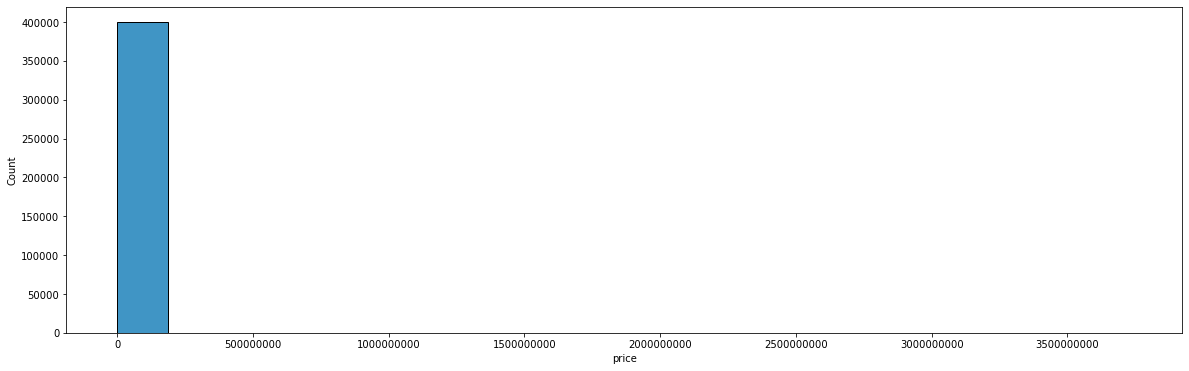

In [29]:
plt.figure(figsize=(20,6))
sns.histplot(data = df["price"], bins = 20)
plt.ticklabel_format(style='plain', axis='x')

Strangely enough we can see that something's with how our data is being represented. Why is our X axis going so far away? At first glance it seems we have some massive **OUTLIERS** that are preventing an accurate representation of the data.

At this point, and based on personal criteria, I decided to visualize an outlier as **any vehicle worth more than 50,000**.

In [30]:
# Let's find out how many outliers we have, as a percentage
df["price"][df["price"] > 50000].shape[0] / df.shape[0] * 100

2.780313241623175

In [31]:
df = df[df["price"] < 50000]

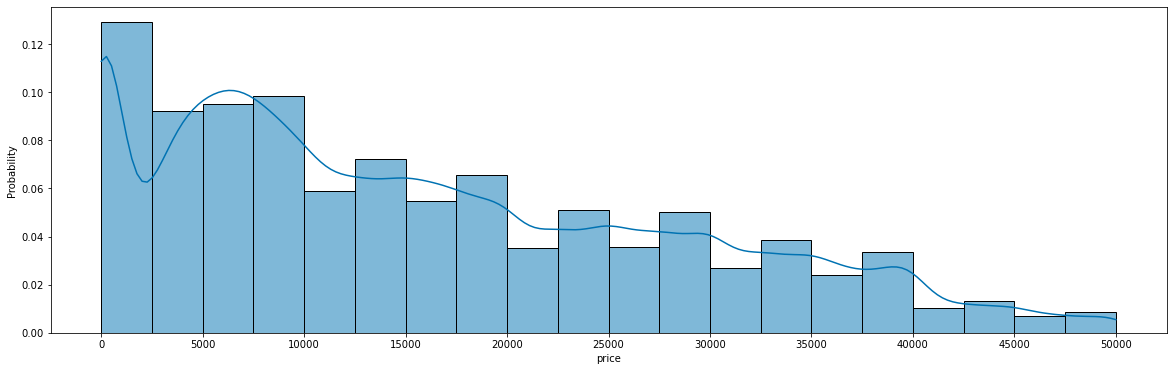

In [32]:
# Let's try visualizing the price distribution now that are rid of outliers 
plt.figure(figsize=(20,6))
ax = sns.histplot(data = df["price"], bins = 20, kde = True, stat = "probability")
# adding ticks every 5,000 USD
ax.xaxis.set_major_locator(MultipleLocator(5000)) 

As it happens with most price related distributions, we can see that the majority of sales / prices are on the left side, cheaper side. In particular, ~42% of sales are below 10,000 USD. A  mental sanity check says this is reasonable as these are used vehicles.

Another interesting insight is that, despite the right-skew of the distribution, the descent or in other words, how far the data goes to the other side, is not very steep. I interpret this as good because it seems we have a captured and understood the underlying behaviour of the data.

Now, my next step would to dive deeper into some of the features and see what else we can find and learn!

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388689 entries, 27 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        388689 non-null  object 
 1   price         388689 non-null  int64  
 2   year          388689 non-null  float64
 3   manufacturer  388689 non-null  object 
 4   model         388689 non-null  object 
 5   condition     388689 non-null  object 
 6   cylinders     388689 non-null  object 
 7   fuel          388689 non-null  object 
 8   odometer      388689 non-null  float64
 9   title_status  388689 non-null  object 
 10  transmission  388689 non-null  object 
 11  drive         388689 non-null  object 
 12  type          388689 non-null  object 
 13  paint_color   388689 non-null  object 
 14  state         388689 non-null  object 
 15  posting_date  388689 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 50.4+ MB


Although most of our data is in text strings, let's try running a correlation analysis to see any / importance of the few numerical features we have

<AxesSubplot:>

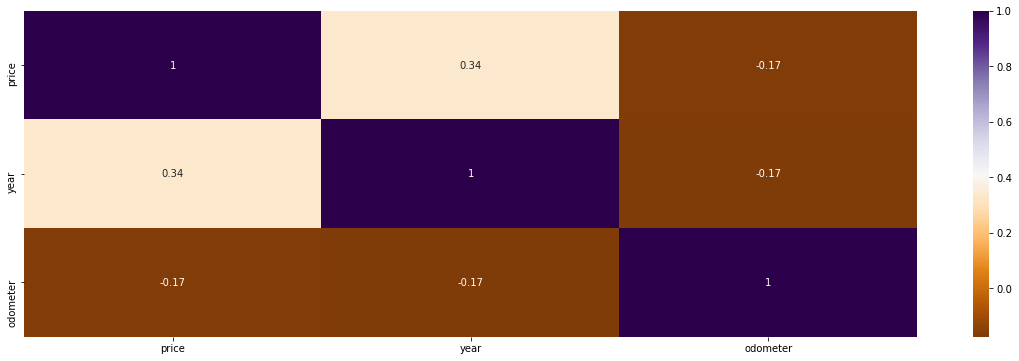

In [34]:
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(), annot = True, cmap="PuOr")

These preliminary observations are interesting and the results for odometer align with one would expect! That is, the more a car has been on the road, the less it is worth.

Nevertheless, there is a problem with year here. Year's correlation is OK, but the direction is counter to logic. The problem might stem that, since these records do not belong a specific year, the car's manufacturing year isn't the most accurate metric for the cars age. In this case we need to calculate a proxy for the vehicles age.

In [35]:
# first, we'll convert the posting date to an actual timestamp
df["posting_date"] = pd.to_datetime(df["posting_date"], utc = True)
df["posting_date"]

27       2021-05-04 17:31:18+00:00
28       2021-05-04 17:31:08+00:00
29       2021-05-04 17:31:25+00:00
30       2021-05-04 15:41:31+00:00
31       2021-05-03 19:02:03+00:00
                    ...           
426875   2021-04-04 09:21:31+00:00
426876   2021-04-04 09:21:29+00:00
426877   2021-04-04 09:21:17+00:00
426878   2021-04-04 09:21:11+00:00
426879   2021-04-04 09:21:07+00:00
Name: posting_date, Length: 388689, dtype: datetime64[ns, UTC]

In [36]:
# In this case what we really care is neither the cars year of manufacture NOR the posting date (this would always be *now* for a new prediction)
# The real variable is the cars AGE which would be -> Current_year - cars_mfg_year
df["age"] = df["posting_date"].dt.year - df["year"] # Extract the year from posting date and substract the cars MFG age to get its "age" at sale time
df["age"].value_counts()

4.0      33705
3.0      33646
6.0      29372
8.0      29119
7.0      28600
         ...  
76.0         1
103.0        1
108.0        1
99.0         1
106.0        1
Name: age, Length: 107, dtype: int64

<AxesSubplot:>

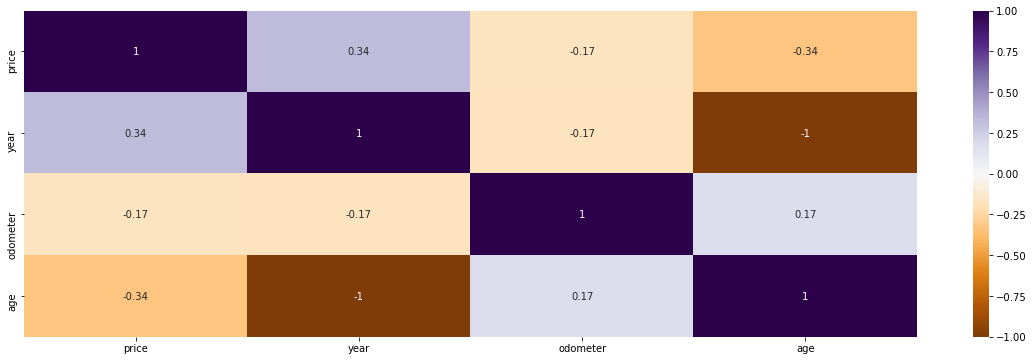

In [37]:
# Let's run correlations again to see if there's any difference
plt.figure(figsize=(20,6))
sns.heatmap(df.corr(), annot = True, cmap="PuOr")

As desired, the feature "age" captures the correct direction of the relationship as one would expect.

In this situation, as the designer of this exercise, I have chosen to preserve **age** as the real predicting variable to maintain as it:
* contains both MFG Year and year of inquire as part of a single variable
* reduces the complexity (even if only by 1 feature) of the model

As such, I will delete both "year" and "posting date"

In [38]:
df = df.drop(columns = ["year", "posting_date"])

Now that we have created the correct proxy variable, let's try visualizing how price behaves in regards to our numerical variables!

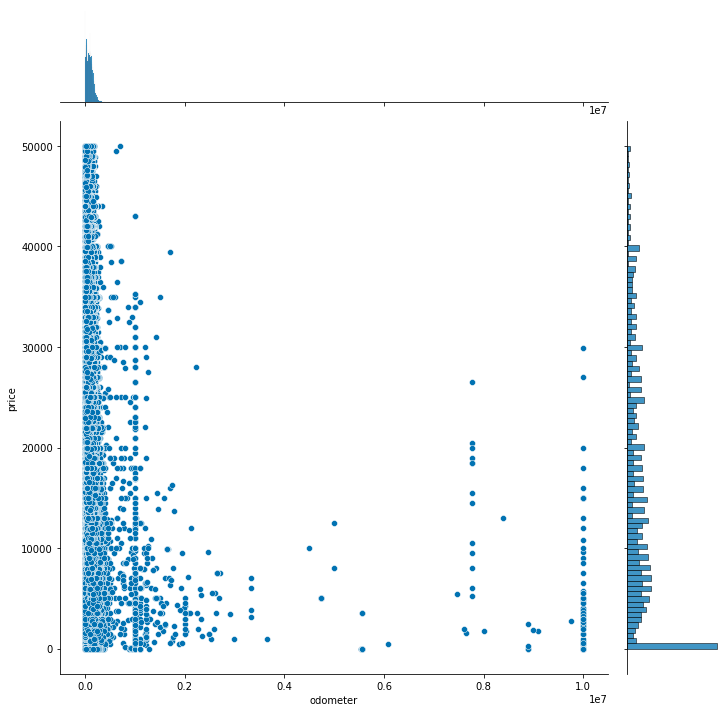

In [55]:
sns.jointplot(data = df, x = "odometer", y = "price", height = 10);

BALBLBLABLABLA

In [39]:
# separating column names for easier plotting
cat_cols = list(df.select_dtypes(include="object").columns)
num_cols = list(df.select_dtypes(include="float64"))

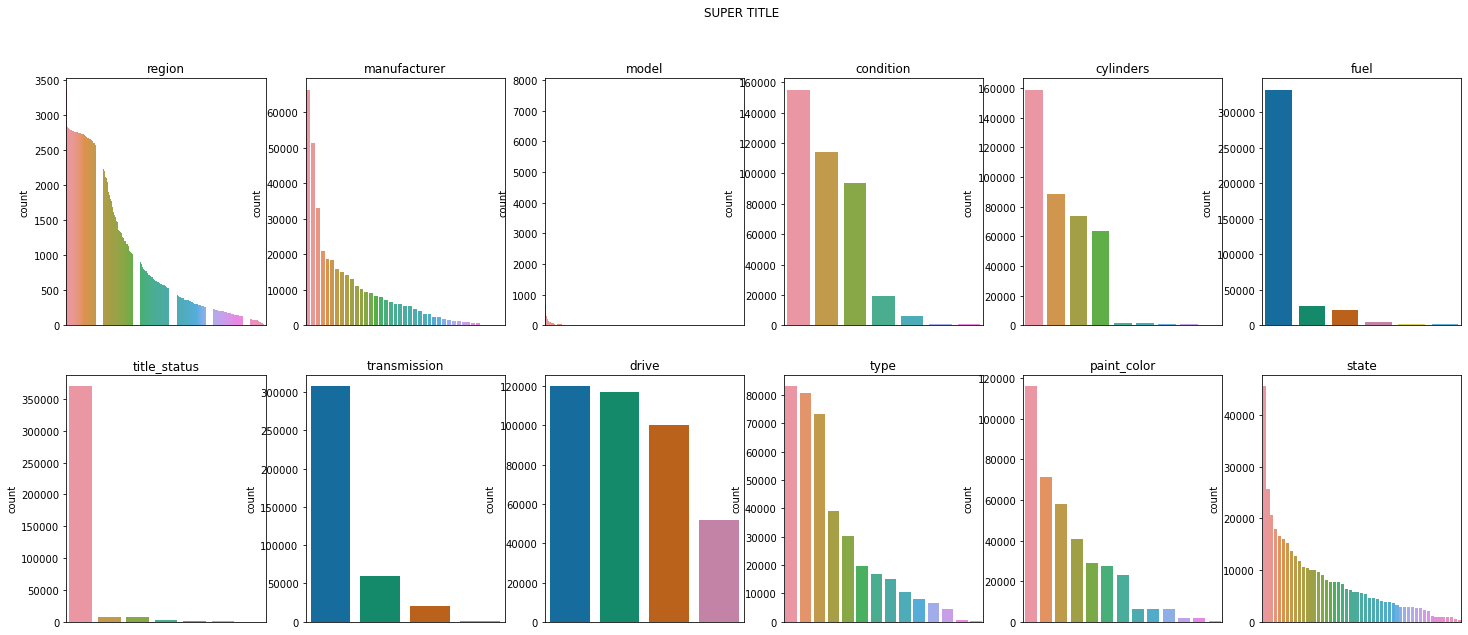

In [43]:
# This will be used only to plot the categorical columns so 6 x 2
fig, ax = plt.subplots(2,6, figsize=(25,10))

# separating rows for easier processing
row_1 = ax[0]
row_2 = ax[1]

# creating plots for the first row
for index, column in enumerate(cat_cols[:6]):
    # creating ax figure in order of value
    sns.countplot(ax=row_1[index], data = df, x=column, order = df[column].value_counts().index)
    # setting plot title
    row_1[index].set_title(column)
    # hiding xaxis since they become unreadable
    row_1[index].get_xaxis().set_visible(False)

# creating plots for the second row
for index, column in enumerate(cat_cols[6:]):
    # creating ax figure in order of value
    sns.countplot(ax=row_2[index], data = df, x=column, order = df[column].value_counts().index)
    # setting plot title
    row_2[index].set_title(column)
    # hiding xaxis since they become unreadable
    row_2[index].get_xaxis().set_visible(False)
    
fig.suptitle("SUPER TITLE");

HERE COMES THE ANALYSIS

These visualizations and exploration, let's see what else we can find through statistical analysis!

Fortunately, Scikit-learn provides some convenient tools for this:
* f_regression -> which is basically a one-way Anova.
* mutual_info_regression -> Analogue to its class counterpart, but for continuous variables

but first, from this point onwards, I will create the Train, Validation and Test splits! This is necessary as we **want to avoid inferences that we are not sure would apply to a ML / DL model that has not seen new data**. As such, the relevant statistics will be obtained using training sets!

In [35]:
# Separating target and features
y = df["price"]
X_parent = df.drop(columns = "price")

In [36]:
# creating first split. The result here is the untouched test splits. The "splits" are a preliminary split that will be separated again for train and validation
X_split, X_test, y_split, y_test = train_test_split(X_parent, y, train_size = 0.8)

In [37]:
# creating the 2nd split. This one creates the train and validation splits
X_train, X_val, y_train, y_val = train_test_split(X_split, y_split, train_size = 0.75)

In [38]:
# first we need to encode the categorical and features since we can't process them as it is
## instantiating scalers
ord_enc = OrdinalEncoder()
norm_sca = StandardScaler()

## separating categorical and numerical features
cat_feats = X_train.select_dtypes(include="object")
num_feats = X_train.select_dtypes(include="float64")

## fitting scalers
ord_enc.fit(cat_feats)
norm_sca.fit(num_feats)

## re-assigning variables
cat_feats = ord_enc.transform(cat_feats)
num_feats = norm_sca.transform(num_feats)

## concatenating arrays
X_stats = np.concatenate([cat_feats, num_feats], axis=1)

In [39]:
f_arrray = f_regression(X_stats, y_train)

In [40]:
mut_info = mutual_info_regression(X_stats, y_train)

In [41]:
# creating a results table
cat_cols = list(X_train.select_dtypes(include="object").columns) # extreacting categorical columns
num_cols = list(X_train.select_dtypes(include="float64")) # extracting numerical columns
cols = cat_cols + num_cols # setting columns in correct order and then merging lists
pd.DataFrame([f_arrray[1], mut_info], index = ["f_regression", "mutual_regre"], columns = cols) #I'm only keeping the p-values of f_regression

,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,type,paint_color,state,odometer,age
f_regression,0.216168,0.010436,0.785732,0.312715,0.455632,0.995189,0.627461,0.502258,0.484876,0.696317,0.858397,0.670374,0.483783,0.024191
mutual_regre,0.425953,0.343351,1.652358,0.352634,0.173883,0.138583,0.044684,0.294615,0.164569,0.317453,0.154778,0.321059,2.039659,0.574376


Before explaining the resulkts found from this analysis I will provide some contextual information:
* f_regression from sklearn is an univariate test that mimics an ANOVA F-TEST but for a continuous problem (like price). More importantly, and as outlined in the functions page itself **IT SHOULDNT BE USED AS A STAND ALONE SELECTION METHOD**. In essence, this trains to calculate how much of the variance of target (price) is explained by the variance of a feature. The value presented in the results table is the p-value associated to the test.
* mutual information for regression is a nonparametrics (does not assume any distribution for the data) test that attempts to find the features that contribute to most to a change in the target feature (price)
* Interestingly, while many of the features had large amounts of missing values which were replaced with placeholder strings, they reflect different behaviours, providing some confidence that the transformation's did not distort the results too much.

That said, the results of both tests provide some interesting, but inconclusive insights:
1. Both methods lack consistency in determining which features might be relevant / contribute more to the variation in price, HOWEVER they do have some agreement into **which features DO NOT contribute much to the variation of the price**. In this sense, the results can be used in reverse to remove features that add little prediction power.
2. Based on the previous point the following features could be considered of LOW relevance:
    1. **TRANSMISSION**: Has a high p-value and low-medium mutual_information score; by both metrics this feature does not contribute much to price. On an individual assessment I find this result accurate as transmission, while important, is not necessarily one's primary concern when choosing a vehicle. **On principle, this feature will be deleted from all splits**
    2. **TITLE_STATUS**: Has a high p-value and low mutual_information score; by both metrics this feature does not contribute much to price. Unfortunately I'm unfamiliar with these intricancies of this feature and what it represents. **On principle, this feature will be deleted from all splits** 
    3. **Region / State**: Has a high p-value and low mutual_information score. by both metrics this feature does not contribute much to price. Interestingly both features capture very similar (if not the same information), as such, one can consider it to be slightly redundant. **On principle, one of these features will be deleted from all splits.
   
After these analysis, we have some strong signals about which features to get rid of, but before any decisive action, let's do some **EXPLORATORY DATA ANALYSIS**.

In [42]:
# deleting unnecessary vars
del ord_enc
del norm_sca
del cat_feats
del num_feats
del X_stats
del cat_cols
del num_cols
del cols